In [1]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 2.7 MB/s eta 0:00:00


In [3]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=a68ed34289332c6f48c91186ca22bdf43982b9fd8aa24cf2abdace023b0aec28
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [37]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Input, Flatten, BatchNormalization, concatenate
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from ta.volatility import BollingerBands
from ta.momentum import StochasticOscillator
import matplotlib.pyplot as plt
import streamlit as st

In [5]:
# Загрузка данных из файла
def load_data_from_file(file_path):
  try:
    data = pd.read_csv(file_path)
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    return data
  except FileNotFoundError:
      print(f"Файл '{file_path}' не найден.")
      return None

# Загрузка данных из yaho finance
def load_data_from_yf(ticker, timeframe='1d'):
  df = yf.download(ticker, interval=timeframe)
  df = df.reset_index()
  if isinstance(df.columns, pd.MultiIndex):
      df.columns = df.columns.droplevel(level=1)
  df['Date'] = pd.to_datetime(df['Date'])
  df.set_index('Date', inplace=True)
  return df

In [6]:
# Индикатор RSI
def rsi(close_prices, n=14):
  delta = close_prices.diff().dropna()
  up = delta.clip(lower=0)
  down = -delta.clip(upper=0)
  rs = up.ewm(span=n, adjust=False).mean() / down.ewm(span=n, adjust=False).mean()
  return 100 - (100 / (1 + rs))

In [9]:
# Колонки для нормализации
columns_to_scale = ['Open', 'High', 'Low', 'Close', 'Volume', 'Mean', 'Value']
# Колонки, которые не нужно нормализовать
columns_not_to_scale = ['Predict', 'SMA', 'RSI', 'MACD', 'Signal_Line', 'ATR', 'bb_high', 'bb_low', 'so']

# Предобработка данных
def preprocess_data(data, window_size=30):
  # Добавление новых признаков
  data['Mean'] = (data['Open']+data['High']+data['Low']+data['Close']) / 4 # Средняя цена
  data['Value'] = data['Volume'] * data['Mean'] # Объём в деньгах
  data['SMA'] = data['Close'].rolling(window_size).mean()  # Скользящая средняя
  data['RSI'] = rsi(data['Close'], n=window_size)  # Индекс относительной силы
  data['MACD'] = data['Close'].ewm(span=12, adjust=False).mean() - data['Close'].ewm(span=26, adjust=False).mean()
  data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()
  data['ATR'] = data['High'] - data['Low']

  # Добавление Bollinger Bands
  indicator_bb = BollingerBands(close=data['Close'], window=20, window_dev=2)
  data['bb_high'] = indicator_bb.bollinger_hband()
  data['bb_low'] = indicator_bb.bollinger_lband()

  # Добавление Stochastic Oscillator
  indicator_so = StochasticOscillator(high=data['High'], low=data['Low'], close=data['Close'], window=14, smooth_window=3)
  data['so'] = indicator_so.stoch()

  # Формирование признака предсказания для стратегии, основанной на использовании GAP,
  # как отношения цены открытия завтра к цене закрытия сегодня
  data["Predict"] = data['Open'].shift(-1) / data["Close"]

  # Удаляем строки с NaN-значениями
  data.dropna(inplace=True)

  # Сохраняем реальные цены закрытия
  Close_prices = data['Close'].values

  # Нормализация данных только к выбранным колонкам
  scaler = MinMaxScaler(feature_range=(0, 1))
  #scaler = StandardScaler()
  #scaler = RobustScaler()
  scaled_data = scaler.fit_transform(data[columns_to_scale])

  # Преобразуем результат обратно в DataFrame
  scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale)

  # Добавляем колонки, которые не нужно было нормализовать
  scaled_df[columns_not_to_scale] = data[columns_not_to_scale].reset_index(drop=True)

  # Сохраняем колонку 'Predict' для целевой переменной
  y_data = scaled_df['Predict'].values

  # Удаление колонки 'Predict' и преобразование DataFrame в массив NumPy для удобства работы
  X_data = scaled_df.drop(columns=['Predict']).values

  # Создание временных окон
  X, y = [], []
  for i in range(window_size, len(scaled_df)):
      X.append(X_data[i - window_size:i, :]) # Все колонки, кроме 'Predict'
      y.append(y_data[i]) # Целевая переменная колонка 'Predict'
  X, y = np.array(X), np.array(y)

  # Разделение на обучающую и тестовую выборки
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

  # Разделение Close_prices в том же отношении, что и X, y
  # Используем индексы, полученные при разбиении X и y
  split_index = len(X_train)
  Close_train = Close_prices[window_size:split_index + window_size]
  Close_test = Close_prices[split_index + window_size:]

  return X_train, X_test, y_train, y_test, Close_train, Close_test, scaler

In [42]:
def create_ensemble_model(input_shape):
    input_layer = Input(shape=input_shape)

    # LSTM ветвь
    lstm_branch = LSTM(50, return_sequences=True)(input_layer)
    lstm_branch = Dropout(0.2)(lstm_branch)
    lstm_branch = LSTM(50, return_sequences=False)(lstm_branch)
    lstm_branch = Dropout(0.2)(lstm_branch)

    # GRU ветвь
    gru_branch = GRU(50, return_sequences=True)(input_layer)
    gru_branch = Dropout(0.2)(gru_branch)
    gru_branch = GRU(50, return_sequences=False)(gru_branch)
    gru_branch = Dropout(0.2)(gru_branch)

    # Объединение ветвей
    merged = concatenate([lstm_branch, gru_branch])

    # Полносвязные слои
    dense_layer = Dense(25, activation='relu')(merged)
    output_layer = Dense(1)(dense_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [11]:
def train_model(model, X_train, y_train, epochs=50, batch_size=32):
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=1)
  return history

In [12]:
def test_model(model, X_test, y_test):
    # Получаем прогнозы
    predictions = model.predict(X_test)
    return predictions, y_test

In [13]:
def calculate_metrics(predictions, y_test):
  # метрика: точность направления движения цены
  pred_sign = np.sign(predictions -1)
  test_sign = np.sign(y_test - 1)
  direction_accuracy = accuracy_score(test_sign, pred_sign)
  rmse = np.mean((predictions - y_test) ** 2) ** 0.5
  mae = np.mean(np.abs(predictions - y_test))
  average = y_test.mean()
  rmse2avg = rmse / average
  mae2avg = mae / average
  return direction_accuracy, rmse, mae, rmse2avg, mae2avg

In [14]:
# Загрузка данных
#file_path = 'stock_data.csv'  # Замените на путь к вашему файлу
#data = load_data_from_file(file_path)
data = load_data_from_yf("AAPL")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [15]:
# Предобработка данных
X_train, X_test, y_train, y_test, Close_train, Close_test, scaler = preprocess_data(data)

In [43]:
# Создание и обучение модели
model = create_ensemble_model((X_train.shape[1], X_train.shape[2]))
history = train_model(model, X_train, y_train, 10)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 0.0710 - val_loss: 0.0026
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - loss: 0.0064 - val_loss: 0.0016
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - loss: 0.0036 - val_loss: 5.0280e-04
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - loss: 0.0027 - val_loss: 7.9812e-04
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - loss: 0.0024 - val_loss: 4.9789e-04
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - loss: 0.0020 - val_loss: 4.4504e-04
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - loss: 0.0020 - val_loss: 5.3777e-04
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - loss: 0.0018 - val_loss: 1.8174e-04
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - loss: 0.0015 - val_loss: 2.6347e-04
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - loss: 0.0013 - val_loss: 1.8608e-04


In [44]:
# Тестирование модели
predictions, y_test = test_model(model, X_test, y_test)

# Расчет метрик
direction_accuracy, rmse, mae, rmse2avg, mae2avg  = calculate_metrics(predictions, y_test)
print(f"Точность направления движения цены: {direction_accuracy:.4f}")
print(f"Средняя абсолютная ошибка цены (MAE): {mae:.4f}")
print(f"Средняя квадратичная ошибка цены (RMSE): {rmse:.4f}")
print(f"Относительная средняя абсолютная ошибка цены (MAE): {mae2avg:.4f}")
print(f"Относительная средняя квадратичная ошибка цены (RMSE): {rmse2avg:.4f}")

70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step
Точность направления движения цены: 0.4831
Средняя абсолютная ошибка цены (MAE): 0.1093
Средняя квадратичная ошибка цены (RMSE): 0.1480
Относительная средняя абсолютная ошибка цены (MAE): 0.1092
Относительная средняя квадратичная ошибка цены (RMSE): 0.1480


In [45]:
count_less_than_1 = np.sum(predictions < 1)
count_great_than_1 = np.sum(predictions > 1)
print(f"Количество элементов меньше 1: {count_less_than_1}")
print(f"Количество элементов больше 1: {count_great_than_1}")

Количество элементов меньше 1: 1858
Количество элементов больше 1: 359


In [46]:
# Сохранение метрик в файл
metrics = {
    'Модель': 'LSTM',
    'Точность направления': direction_accuracy,
    'Средняя абсолютная ошибка': mae,
    'Средняя квадратичная ошибка': rmse,
    'Относительная средняя абсолютная ошибка': mae2avg,
    'Относительная средняя квадратичная ошибка': rmse2avg
}
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv('metrics.csv', index=False)

In [47]:
# Создание дашборда с использованием Streamlit
def create_dashboard(data, predictions, y_test):
    st.title('Дашборд торговой стратегии')
    st.write("### График прогнозов и реальных цен")
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Реальные цены')
    plt.plot(predictions, label='Прогнозы')
    plt.legend()
    st.pyplot(plt)

    st.write("### Метрики модели")
    metrics_df = pd.read_csv('metrics.csv')
    st.table(metrics_df)

2025-03-02 13:50:33.354 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-02 13:50:33.441 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-03-02 13:50:33.442 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-02 13:50:33.444 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-02 13:50:33.444 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-02 13:50:33.445 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-02 13:50:33.446 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-02 13:50:33.467 Thread 'MainThread': mi

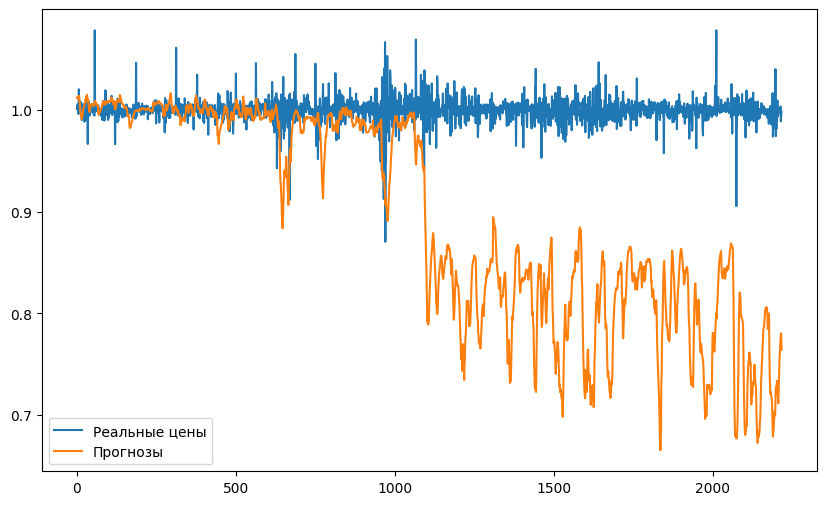

In [48]:
create_dashboard(data, predictions, y_test)

In [49]:
def simulate_trading(predictions, Close_prices, initial_capital=10000, commission=0.001):
    """
    Симуляция торговли на тестовых данных.
    Будем покупать акции, если модель предсказывает рост цены, и продавать, если предсказывает падение
    :param predictions: предсказания модели
    :param Close_prices: Реальные цены закрытия
    :param initial_capital: Начальный капитал
    :param commission: Комиссия за сделку (например, 0.1%)
    :return: История капитала, список сделок
    """
    # Инициализация переменных
    capital = initial_capital
    position = 0  # Текущая позиция (0 - нет позиции, 1 - куплено, -1 - продано)
    trades = []  # Список для хранения сделок
    capital_history = []  # История изменения капитала

    for i in range(len(predictions) - 1):
        current_price = Close_prices[i]
        predicted_change = predictions[i] - 1

        # Сигнал на покупку (предсказание роста)
        if predicted_change > 0 and position <= 0:
            if position == -1:
                # Закрываем короткую позицию (покупаем)
                capital += position * current_price * (1 - commission)
                position = 0
            # Покупаем
            shares_to_buy = capital // (current_price * (1 + commission))
            if shares_to_buy > 0:
                capital -= shares_to_buy * current_price * (1 + commission)
                position = 1
                trades.append(('buy', current_price, shares_to_buy))

        # Сигнал на продажу (предсказание падения)
        elif predicted_change < 0 and position >= 0:
            if position == 1:
                # Закрываем длинную позицию (продаем)
                capital += position * current_price * (1 - commission)
                position = 0
            # Продаем (шорт)
            shares_to_sell = capital // (current_price * (1 + commission))
            if shares_to_sell > 0:
                capital += shares_to_sell * current_price * (1 - commission)
                position = -1
                trades.append(('sell', current_price, shares_to_sell))

        # Обновляем историю капитала
        if position == 1:
            capital_history.append(capital + (shares_to_buy * current_price))
        elif position == -1:
            capital_history.append(capital - (shares_to_sell * current_price))
        else:
            capital_history.append(capital)

    # Закрываем последнюю позицию, если она открыта
    if position == 1:
        capital += position * Close_prices[-1] * (1 - commission)
    elif position == -1:
        capital += position * Close_prices[-1] * (1 - commission)

    return capital_history, trades

In [50]:
# Симуляция торговли с учетом стоп-лосса и тейк-профита
def simulate_trading_optimized(predictions, Close_prices, initial_capital=10000, commission=0.001, stop_loss=0.02, take_profit=0.03):
    """
    Симуляция торговли на тестовых данных.
    Будем покупать акции, если модель предсказывает рост цены, и продавать, если предсказывает падение
    :param predictions: предсказания модели
    :param Close_prices: Реальные цены закрытия
    :param initial_capital: Начальный капитал
    :param commission: Комиссия за сделку (например, 0.1%)
    :return: История капитала, список сделок
    """
    capital = initial_capital
    position = 0
    trades = []
    capital_history = []

    for i in range(len(predictions) - 1):
        current_price = Close_prices[i]
        predicted_change = predictions[i] - 1

        if predicted_change > 0 and position <= 0:
            if position == -1:
                capital += position * current_price * (1 - commission)
                position = 0
            shares_to_buy = capital // (current_price * (1 + commission))
            if shares_to_buy > 0:
                capital -= shares_to_buy * current_price * (1 + commission)
                position = 1
                trades.append(('buy', current_price, shares_to_buy, 'stop_loss', current_price * (1 - stop_loss), 'take_profit', current_price * (1 + take_profit)))

        elif predicted_change < 0 and position >= 0:
            if position == 1:
                capital += position * current_price * (1 - commission)
                position = 0
            shares_to_sell = capital // (current_price * (1 + commission))
            if shares_to_sell > 0:
                capital += shares_to_sell * current_price * (1 - commission)
                position = -1
                trades.append(('sell', current_price, shares_to_sell, 'stop_loss', current_price * (1 + stop_loss), 'take_profit', current_price * (1 - take_profit)))

        # Проверка на стоп-лосс и тейк-профит
        if position == 1:
            if current_price <= trades[-1][4]:  # stop_loss
                capital += position * current_price * (1 - commission)
                position = 0
            elif current_price >= trades[-1][6]:  # take_profit
                capital += position * current_price * (1 - commission)
                position = 0
        elif position == -1:
            if current_price >= trades[-1][4]:  # stop_loss
                capital += position * current_price * (1 - commission)
                position = 0
            elif current_price <= trades[-1][6]:  # take_profit
                capital += position * current_price * (1 - commission)
                position = 0

        capital_history.append(capital)

    return capital_history, trades

In [51]:
# Симуляция торгов
capital_history, trades = simulate_trading(predictions, Close_test, initial_capital=10000, commission=0.001)
# Вывод результатов
print(f"Конечный капитал: {capital_history[-1]:.2f}")
print(f"Количество сделок: {len(trades)}")
print(f"Первые 5 сделок: {trades[:5]}")

Конечный капитал: 24.48
Количество сделок: 8
Первые 5 сделок: [('buy', 21.33820343017578, 468.0), ('sell', 21.791330337524414, 1.0), ('buy', 22.40923500061035, 1.0), ('sell', 21.878297805786133, 1.0), ('buy', 21.94466209411621, 1.0)]


In [52]:
# Симуляция торгов
capital_history, trades = simulate_trading_optimized(predictions, Close_test, initial_capital=10000, commission=0.001)
# Вывод результатов
print(f"Конечный капитал: {capital_history[-1]:.2f}")
print(f"Количество сделок: {len(trades)}")
print(f"Первые 5 сделок: {trades[:5]}")

Конечный капитал: 24.13
Количество сделок: 17
Первые 5 сделок: [('buy', 21.33820343017578, 468.0, 'stop_loss', 20.911439361572267, 'take_profit', 21.978349533081055), ('buy', 20.715723037719727, 1.0, 'stop_loss', 20.301408576965333, 'take_profit', 21.33719472885132), ('buy', 21.39542007446289, 1.0, 'stop_loss', 20.967511672973632, 'take_profit', 22.037282676696776), ('sell', 21.791330337524414, 1.0, 'stop_loss', 22.227156944274903, 'take_profit', 21.13759042739868), ('sell', 22.798288345336914, 1.0, 'stop_loss', 23.254254112243654, 'take_profit', 22.114339694976806)]


In [53]:
# Добавление графика капитала в дашборд
def create_dashboard2(data, predictions, y_test, capital_history):
    st.title('Дашборд торговой стратегии')
    st.write("### График прогнозов и реальных цен")
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(y_test, label='Реальные цены')
    ax.plot(predictions, label='Прогнозы')
    ax.legend()
    st.pyplot(fig)

    st.write("### График изменения капитала")
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(capital_history, label='Капитал')
    ax.set_xlabel('Время')
    ax.set_ylabel('Капитал')
    ax.legend()
    st.pyplot(fig)

    st.write("### Метрики модели")
    metrics_df = pd.read_csv('metrics.csv')
    st.table(metrics_df)

In [54]:
create_dashboard2(data, predictions, y_test, capital_history)

2025-03-02 13:51:40.816 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-02 13:51:40.817 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-02 13:51:40.818 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-02 13:51:40.819 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-02 13:51:40.820 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-02 13:51:40.821 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-02 13:51:40.838 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-02 13:51:41.263 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

ВЫВОДЫ:
1. Модель плохо обучается по предсказыванию целевой величины и поэтому всегда предсказывает только повышение
2. Торговая стратегия не генерирует прибыль